## Prerequisite

Make sure you ran `snakemake` in this directory and have obtained all the files (stored under `output/`).

## Load and visualize the predictions

In [53]:
# Gloal 
models = ['rbp']

### Loading predictions from the tsv output

In [54]:
import kipoi
import seaborn as sns
import pandas as pd

In [55]:
merge_cols = ['variant_chr', 'variant_pos', 'variant_ref', 'variant_alt', 'variant_id', 'line_idx', 'vcf_set']

In [56]:
def read_preds_tsv(model, vcf_set, output_dir):
    df = pd.read_table("{}/{}/{}.tsv".format(output_dir, vcf_set, model))
    df['vcf_set'] = vcf_set
    df.set_index(merge_cols, inplace=True)
    assert df.columns.str.startswith("preds").all()
    
    # TODO - update
    df.columns = df.columns.str.replace("preds", model)
    
    if len(df.columns) > 1:
        # multi-task model
        try:
            descr = kipoi.get_model_descr(model)
            df.columns = model + "/" + pd.Series(descr.schema.targets.column_labels)
        except:
            pass
    return df

In [57]:
df = pd.concat([read_preds_tsv(m, vcf_set='variants', output_dir='output') for m in models], axis=1)

In [58]:
df.head()

rbp/alt/rbp_prb  \
variant_chr variant_pos variant_ref variant_alt variant_id line_idx               vcf_set                     
chr22       21541590    A           T           rs1111     chr22:21541590:A:['T'] variants          -0.0484   
            21541952    C           C           rs1112     chr22:21541952:C:['C'] variants          -0.0284   
            30630220    T           G           rs1113     chr22:30630220:T:['G'] variants           0.1119   
            30630701    A           G           rs1114     chr22:30630701:A:['G'] variants          -0.2984   
            35503223    C           A           rs1115     chr22:35503223:C:['A'] variants           0.3138   

                                                                                            rbp/diff/rbp_prb  \
variant_chr variant_pos variant_ref variant_alt variant_id line_idx               vcf_set                      
chr22       21541590    A           T           rs1111     chr22:21541590:A:['T'] variants            0.0172   
            21541952    C           C           rs1112     chr22:21541952:C:['C'] variants            0.0000   
            30630220    T           G           rs1113     chr22:30630220:T:['G'] variants            0.0179   
            30630701    A           G           rs1114     chr22:30630701:A:['G'] variants            0.0322   
            35503223    C           A           rs1115     chr22:35503223:C:['A'] variants           -0.0292   

                                                                                            rbp/ref/rbp_prb  
variant_chr variant_pos variant_ref variant_alt variant_id line_idx               vcf_set                    
chr22       21541590    A           T           rs1111     chr22:21541590:A:['T'] variants          -0.0656  
            21541952    C           C           rs1112     chr22:21541952:C:['C'] variants          -0.0284  
            30630220    T           G           rs1113     chr22:30630220:T:['G'] variants           0.0940  
            30630701    A           G           rs1114     chr22:30630701:A:['G'] variants          -0.3305  
            35503223    C           A           rs1115     chr22:35503223:C:['A'] variants           0.3429

Text(34,0.5,'Variant')

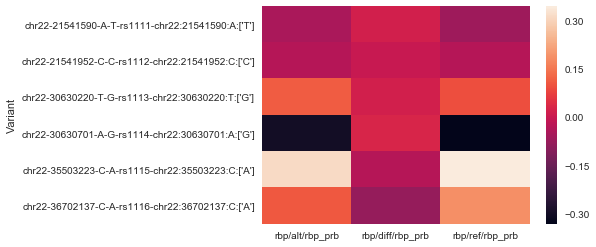

In [36]:
sns.heatmap(df)
plt.ylabel("Variant")

### Loading predictions from the hdf5 output

In [37]:
from kipoi.readers import HDF5Reader

List of entries:

In [38]:
f = "output/variants/rbp.h5"

In [39]:
r = HDF5Reader(f)
r.open()

In [40]:
r.ls()

[('/line_idx', <HDF5 dataset "line_idx": shape (6,), type "|O">),
 ('/preds/alt/rbp_prb', <HDF5 dataset "rbp_prb": shape (6,), type "<f4">),
 ('/preds/diff/rbp_prb', <HDF5 dataset "rbp_prb": shape (6,), type "<f4">),
 ('/preds/ref/rbp_prb', <HDF5 dataset "rbp_prb": shape (6,), type "<f4">),
 ('/variant_alt', <HDF5 dataset "variant_alt": shape (6,), type "|O">),
 ('/variant_chr', <HDF5 dataset "variant_chr": shape (6,), type "|O">),
 ('/variant_id', <HDF5 dataset "variant_id": shape (6,), type "|O">),
 ('/variant_pos', <HDF5 dataset "variant_pos": shape (6,), type "<i8">),
 ('/variant_ref', <HDF5 dataset "variant_ref": shape (6,), type "|O">)]

In [41]:
# load the values
d = HDF5Reader.load(f, unflatten=False)

In [42]:
d.keys()

dict_keys(['/line_idx', '/preds/alt/rbp_prb', '/preds/diff/rbp_prb', '/preds/ref/rbp_prb', '/variant_alt', '/variant_chr', '/variant_id', '/variant_pos', '/variant_ref'])

In [59]:
def df2index(df):
    return pd.MultiIndex.from_arrays([df.values[:,i] for i in range(df.shape[1])], names=list(df.columns))


def read_preds_h5(model, vcf_set, output_dir, scoring_fn='diff'):
    d = HDF5Reader.load("{}/{}/{}.h5".format(output_dir, vcf_set, model), unflatten=False)
    preds = d.pop(f"/preds/{scoring_fn}/{model}_prb")
    
    if preds.ndim == 1:
        preds = preds[:, np.newaxis]
    assert preds.ndim == 2  # this example works only with 2 dim output arrays
    
    metadata_table = pd.DataFrame(d)
    metadata_table.columns = metadata_table.columns.str.replace("^/", "")
    metadata_table['vcf_set'] = vcf_set
    metadata_table = metadata_table[merge_cols]  # re-order
    
    if preds.shape[1] > 1 and model != 'Basset':
        # TODO - remove
        descr = kipoi.get_model_descr(model)
        return pd.DataFrame(preds, 
                            columns=model + "/" + pd.Series(descr.schema.targets.column_labels),
                            index=df2index(metadata_table))
    else:
        return pd.DataFrame(preds, columns = model + "/" + pd.Series(np.arange(preds.shape[1]), dtype=str),
                            index=df2index(metadata_table))

In [60]:
df = pd.concat([read_preds_h5(m, 'variants', output_dir='output') for m in models], axis=1)

In [61]:
df.head()

rbp/0
variant_chr variant_pos variant_ref variant_alt variant_id line_idx               vcf_set         
chr22       21541590    A           T           rs1111     chr22:21541590:A:['T'] variants  0.0172
            21541952    C           C           rs1112     chr22:21541952:C:['C'] variants  0.0000
            30630220    T           G           rs1113     chr22:30630220:T:['G'] variants  0.0179
            30630701    A           G           rs1114     chr22:30630701:A:['G'] variants  0.0322
            35503223    C           A           rs1115     chr22:35503223:C:['A'] variants -0.0292